In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelBinarizer

In [2]:
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
pd.options.display.float_format = '{:.0f}'.format

In [3]:
import plotly.offline as off

off.init_notebook_mode(connected=False) # allows for offline mode

import plotly.figure_factory as ff
import plotly.graph_objs as go

In [4]:
import xgboost as xgb
sns.set_style("whitegrid")
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
from sklearn.tree import plot_tree

In [7]:
pd.set_option('precision',1)

In [8]:
adf = pd.read_csv('eons/safr_archean.tsv',sep='\t')
prdf = pd.read_csv('eons/safr_proterozoic.tsv',sep='\t')
phdf = pd.read_csv('eons/safr_phanerozoic.tsv',sep='\t')

In [9]:
df = pd.concat([adf,prdf,phdf],ignore_index=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Columns: 151 entries, SAMPLE ID to GER.1
dtypes: float64(141), object(10)
memory usage: 3.5+ MB


In [11]:
def fe23(feo,fe2o3):
    if (feo==np.nan) and (fe2o3==np.nan):
        return np.nan
    elif (feo==np.nan):
        return 2*71.94*fe2o3/159.69
    elif (fe2o3==np.nan):
        return feo
    else:
        return feo+2*71.94*fe2o3/159.69

In [12]:
df['FEOCALC']=df['FEO'].combine(df['FE2O3'],fe23)

In [13]:
df['FEO_23']=df['FE2O3T']*2*71.94/159.69

In [14]:
df['FEO_INT']=df['FEOT'].combine_first(df['FEOCALC'])
df['FEOTOTAL']=df['FEO_INT'].combine_first(df['FEO_23'])

In [15]:
df['H2O']=df['H2O'].combine_first(df['H2O_M'])

In [16]:
major_df = df[(df['SIO2'] > 40.0) & (df['SIO2'] < 80.0)]

For the record, the BS problem data at high SiO2 look like they are all the in Archean data: SiO2 stupidly high, other oxides low so at least they sum to 100% or could, all the mislabeled rocks appear to be Archean.

In [17]:
major_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2180 entries, 0 to 2998
Columns: 155 entries, SAMPLE ID to FEOTOTAL
dtypes: float64(145), object(10)
memory usage: 2.6+ MB


In [18]:
#major_only = major_df[['SIO2','TIO2','AL2O3','FEOTOTAL','MNO',
#                      'MGO','CAO','NA2O','K2O','P2O5','H2O','CO2','LOI']]
major_only = major_df[['EON','SIO2','TIO2','AL2O3','FEOTOTAL','MNO',
                      'MGO','CAO','NA2O','K2O','P2O5',
                      'TYPE','COMPOSITION','ROCK NAME']].copy()

In [19]:
major_only.fillna(value=0.0,inplace=True)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(
    major_only.drop(['EON','TYPE','COMPOSITION','ROCK NAME'],axis=1)
                                                 ,major_only['EON'])

In [21]:
rfc_majors = RandomForestClassifier()
rfc_majors.fit(X_train,y_train)
rfc_majors.score(X_train,y_train)

1.0

In [22]:
rfc_majors.score(X_test,y_test)

0.9027522935779817

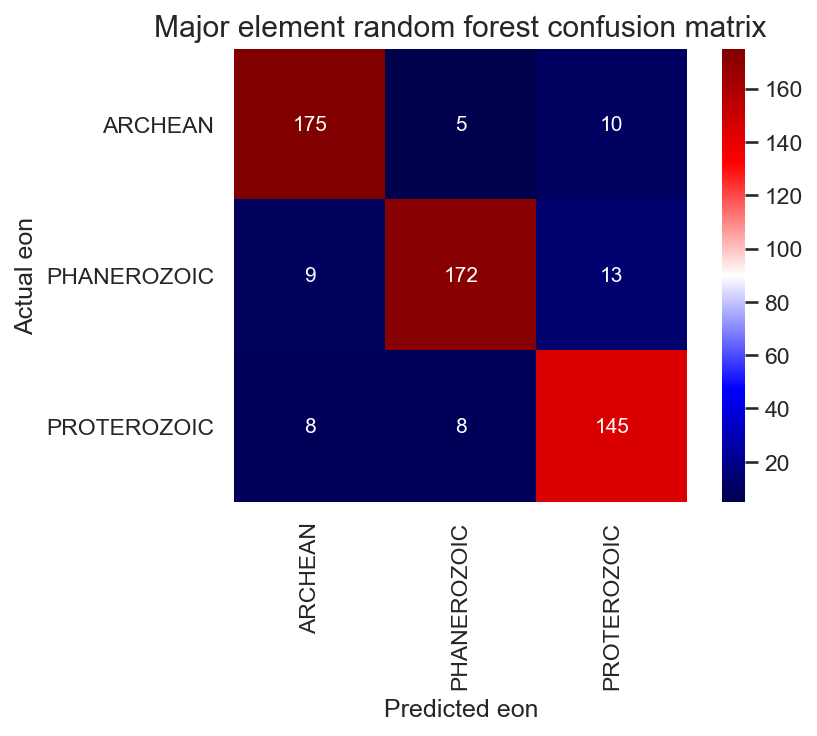

In [23]:
rfc_confusion = confusion_matrix(y_test, rfc_majors.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rfc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=rfc_majors.classes_,
           yticklabels=rfc_majors.classes_,
           fmt=".0f")

plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major element random forest confusion matrix');

Let's get some plotly up in here.

Let's do a TAS diagram. In case this text winds up in front of ye instructors or TAs, a TAS diagram is a standard plot used to name igneous rocks in these latter days. It's SiO2 on the x-axis versus "total alkalis" = Na2O + K2O on the y-axis, like so: https://www.researchgate.net/profile/Stefan_Marincea/publication/259331690/figure/fig5/AS:297105957638149@1447846988245/TAS-diagram-Le-Maitre-1989-of-magmatic-rocks-from-the-ECSZ-Legend-of-symbols_W640.jpg

Oooh. I wonder how hard it would be to yank the boundary lines between different rock types and have plotly tell you what the rock type is when you hover over it. A tooltip saying "phonolite" would be HOT. No, you don't understand.

Oh, that's right, there are carbonatites in this dataset down at stupid, stupid low SiO2. There are some phenomenally alkalic rocks in there too (compare to the figure I linked above).

Probably would be interesting to see these break down by eon.

In [23]:
# Archean
archean = go.Scatter(
    x = major_only[major_only['EON']=='ARCHEAN']['SIO2'],
    y = major_only[major_only['EON']=='ARCHEAN']['NA2O']+ \
        major_only[major_only['EON']=='ARCHEAN']['K2O'],
    name = 'Archean',
    mode = 'markers',
    marker = dict(
        size=12,
        color='red',
        opacity=0.5,
        line=dict(width=1)
    ),
    text=major_only['ROCK NAME'],
    hovertemplate = '<i>%{text}</i>',
)

# Proterozoic
protero = go.Scatter(
    x = major_only[major_only['EON']=='PROTEROZOIC']['SIO2'],
    y = major_only[major_only['EON']=='PROTEROZOIC']['NA2O']+ \
        major_only[major_only['EON']=='PROTEROZOIC']['K2O'],
    name = 'Proterozoic',
    mode = 'markers',
    marker = dict(
        size=12,
        color='green',
        line=dict(width=1)
    ),
    text=major_only['ROCK NAME'],
    hovertemplate = '<i>%{text}</i>',
)

# Phanerozoic
phanero = go.Scatter(
    x = major_only[major_only['EON']=='PHANEROZOIC']['SIO2'],
    y = major_only[major_only['EON']=='PHANEROZOIC']['NA2O']+ \
        major_only[major_only['EON']=='PHANEROZOIC']['K2O'],
    name = 'Phanerozoic',
    mode = 'markers',
    marker = dict(
        size=12,
        color='blue',
        line=dict(width=1)
    ),
    text=major_only['ROCK NAME'],
    hovertemplate = '<i>%{text}</i>',
)

data=[archean, protero, phanero]

# Modify layout
layout = dict(
    title = 'TAS plot by geologic eon for EarthChem Southern Africa data',
    xaxis = dict(
        title = 'SiO2, wt%',
        zeroline = False
    ),
    yaxis = dict(
        title = 'Na2O + K2O, wt%',
        hoverformat = '.1f'
    ),
    hovermode= 'closest'  #Point 3. Include to activate tooltip for closest datapoint.
)

off.iplot(dict(data=data, layout=layout))

I'm concerned about these tooltips and the underlying dataframe. There seem to be mislabeled Proterozoic rocks in places where the underlying tsv file doesn't have mislabeled rocks.

The rock names are sadly NOT calculated, of course; I'm grabbing a column from the data that the contributors supplied (or didn't). This plot shows that there is a lot of cleanup to do. I was too brain-dead to notice it before, but basically anything with SiO2 above 80 is LIES, LIES, especially if the rock is labeled "basalt". A lot of the really low SiO2 data is also labeled as some normal rock type that would have to have over 40% SiO2. In fact, tons and tons of these labels do not match the SiO2 content.

On the plus side, these rocks overlap in TAS space quite a bit, so whatever the random forest classifier is doing, it's not merely exploiting some sort of obvious sampling bias where the Archean rocks were all greenstones and the Proterozoic rocks were all granite and the Phanerozoic rocks were all andesite or something.

I want to see what a support vector machine would do, potentially with a nonlinear kernel...actually, the nonlinear kernel sucked due to my not standardizing the variables.

In [24]:
svc_model = SVC(kernel='linear')
svc_model.fit(X_train,y_train)
svc_model.score(X_train,y_train)

0.7590214067278287

In [25]:
svc_model.score(X_test,y_test)

0.7137614678899082

Finally, we can't not try gradient boosted trees.

In [26]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_model.score(X_train,y_train)

0.9688073394495413

In [27]:
gb_model.score(X_test,y_test)

0.8935779816513761

That's intriguing. The models perform basically identically with or without the few hundred data points of either junk or wacky rocks that I cut out by trimming to 40% < SiO2 < 80%.

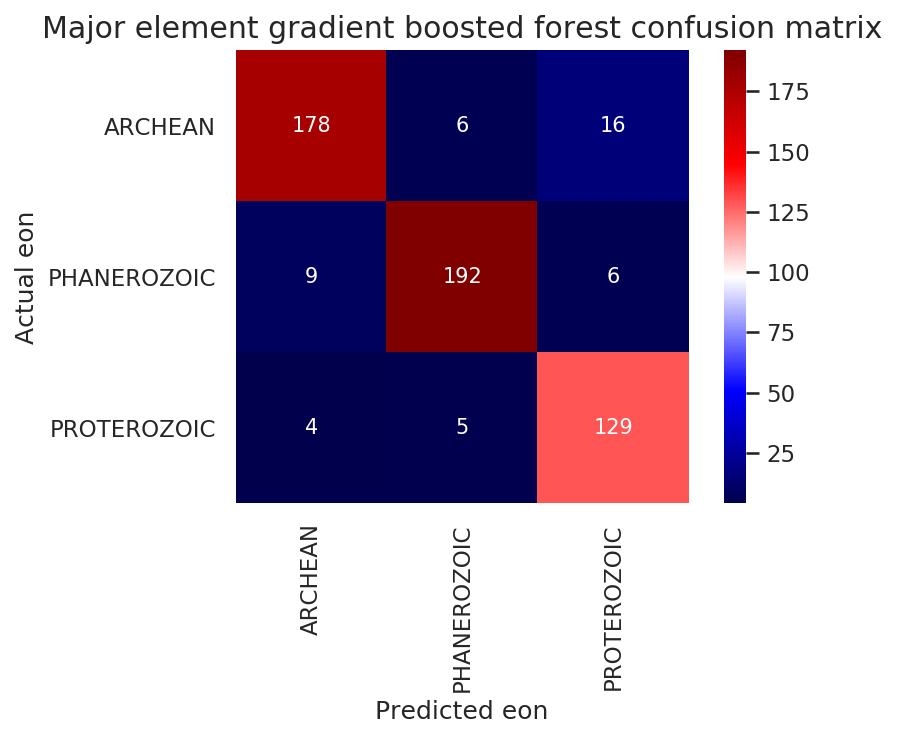

In [28]:
gb_confusion = confusion_matrix(y_test, gb_model.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(gb_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=gb_model.classes_,
           yticklabels=gb_model.classes_,
           fmt=".0f")

plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major element gradient boosted forest confusion matrix');

So apparently I can't do ROC curves on three-way classifications. I need a positive and a negative. Right. Do I cut out Archean vs. Cold Earth or Phanerozoic vs. Precambrian? I want the biggest difference in bin size, and Phanerozoic is a tad smaller than Archean in the S. African data, so there we go.

Actually, the right choice is to do both, isn't it? I could also split out Proterozoic... but I don't have THAT much time.

In [28]:
def code_phan(eon):
    if eon == 'PHANEROZOIC':
        return 1
    else:
        return 0
    
def code_arch(eon):
    if eon == 'ARCHEAN':
        return 1
    else:
        return 0

In [29]:
major_only['CODEP']=major_only['EON'].map(code_phan)

In [30]:
major_only['CODEA']=major_only['EON'].map(code_arch)

As curious as I am about SVC, I'll do it regardless of the fact that its score is so low.

In [31]:
X_train,X_test,y_train,y_test = train_test_split(
    major_only.drop(['EON','TYPE','COMPOSITION','ROCK NAME','CODEA','CODEP'],axis=1),
    major_only['CODEA'])

In [32]:
svc_arch=SVC(kernel='linear')
svc_arch.fit(X_train,y_train)
print("Train score: ",svc_arch.score(X_train,y_train))
print("Test score: ",svc_arch.score(X_test,y_test))

Train score:  0.7785932721712538
Test score:  0.7889908256880734


In [33]:
rfc_arch=RandomForestClassifier()
rfc_arch.fit(X_train,y_train)
print("Train score: ",rfc_arch.score(X_train,y_train))
print("Test score: ",rfc_arch.score(X_test,y_test))

Train score:  1.0
Test score:  0.9412844036697248


In [34]:
gbf_arch=GradientBoostingClassifier()
gbf_arch.fit(X_train,y_train)
print("Train score: ",gbf_arch.score(X_train,y_train))
print("Test score: ",gbf_arch.score(X_test,y_test))

Train score:  0.9779816513761468
Test score:  0.908256880733945


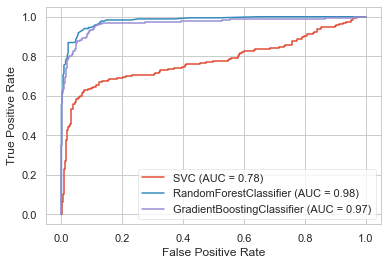

In [35]:
ax = plt.gca()
svc_plot = plot_roc_curve(svc_arch,X_test,y_test,ax=ax)
rfc_plot = plot_roc_curve(rfc_arch,X_test,y_test,ax=ax)
gbf_plot = plot_roc_curve(gbf_arch,X_test,y_test,ax=ax)
plt.show()

In [36]:
X_train,X_test,y_train,y_test = train_test_split(
    major_only.drop(['EON','TYPE','COMPOSITION','ROCK NAME','CODEA','CODEP'],axis=1),
    major_only['CODEP'])

In [37]:
svc_phan=SVC(kernel='linear')
svc_phan.fit(X_train,y_train)
print("Train score: ",svc_phan.score(X_train,y_train))
print("Test score: ",svc_phan.score(X_test,y_test))

Train score:  0.8501529051987767
Test score:  0.8403669724770643


In [38]:
rfc_phan=RandomForestClassifier()
rfc_phan.fit(X_train,y_train)
print("Train score: ",rfc_phan.score(X_train,y_train))
print("Test score: ",rfc_phan.score(X_test,y_test))

Train score:  1.0
Test score:  0.9376146788990826


In [39]:
gbf_phan=GradientBoostingClassifier()
gbf_phan.fit(X_train,y_train)
print("Train score: ",gbf_phan.score(X_train,y_train))
print("Test score: ",gbf_phan.score(X_test,y_test))

Train score:  0.9669724770642202
Test score:  0.9137614678899083


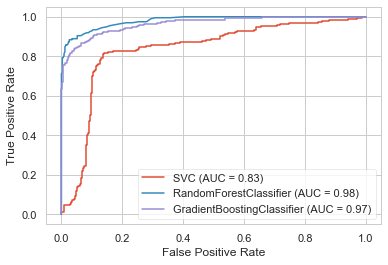

In [40]:
ax = plt.gca()
svc_plot = plot_roc_curve(svc_phan,X_test,y_test,ax=ax)
rfc_plot = plot_roc_curve(rfc_phan,X_test,y_test,ax=ax)
gbf_plot = plot_roc_curve(gbf_phan,X_test,y_test,ax=ax)
plt.show()

Let's check cross-validation.

In [41]:
X = major_only.drop(['EON','TYPE','COMPOSITION','ROCK NAME','CODEA','CODEP'],axis=1)
yo = major_only['EON']

In [43]:
svc_cross = SVC(kernel='linear')
svc_scores = cross_val_score(svc_cross,X,yo)
print("\nMean SVC score: ",np.mean(svc_scores))
print("Individual scores: ",svc_scores)

rfc_cross = RandomForestClassifier()
rfc_scores = cross_val_score(rfc_cross,X,yo)
print("\nMean random forest regression score: ",np.mean(rfc_scores))
print("Individual scores: ",rfc_scores)

gbf_cross = GradientBoostingClassifier()
gbf_scores = cross_val_score(gbf_cross,X,yo)
print("\nMean gradient boosted regression score: ",np.mean(gbf_scores))
print("Individual scores: ",gbf_scores)


Mean SVC score:  0.6995412844036697
Individual scores:  [0.58256881 0.71330275 0.79587156 0.71559633 0.69036697]

Mean random forest regression score:  0.8371559633027523
Individual scores:  [0.7293578  0.77293578 0.96100917 0.92889908 0.79357798]

Mean gradient boosted regression score:  0.8229357798165138
Individual scores:  [0.71559633 0.76146789 0.94954128 0.91055046 0.77752294]


In [44]:
yo=major_only['CODEA']

In [45]:
svc_cross = SVC(kernel='linear')
svc_scores = cross_val_score(svc_cross,X,yo)
print("\nMean SVC score: ",np.mean(svc_scores))
print("Individual scores: ",svc_scores)

rfc_cross = RandomForestClassifier()
rfc_scores = cross_val_score(rfc_cross,X,yo)
print("\nMean random forest regression score: ",np.mean(rfc_scores))
print("Individual scores: ",rfc_scores)

gbf_cross = GradientBoostingClassifier()
gbf_scores = cross_val_score(gbf_cross,X,yo)
print("\nMean gradient boosted regression score: ",np.mean(gbf_scores))
print("Individual scores: ",gbf_scores)


Mean SVC score:  0.7522935779816514
Individual scores:  [0.77752294 0.81192661 0.67201835 0.74311927 0.75688073]

Mean random forest regression score:  0.894954128440367
Individual scores:  [0.87614679 0.92889908 0.89678899 0.90366972 0.86926606]

Mean gradient boosted regression score:  0.886697247706422
Individual scores:  [0.88761468 0.90825688 0.88761468 0.89220183 0.85779817]


In [46]:
yo = major_only['CODEP']

In [47]:
svc_cross = SVC(kernel='linear')
svc_scores = cross_val_score(svc_cross,X,yo)
print("\nMean SVC score: ",np.mean(svc_scores))
print("Individual scores: ",svc_scores)

rfc_cross = RandomForestClassifier()
rfc_scores = cross_val_score(rfc_cross,X,yo)
print("\nMean random forest regression score: ",np.mean(rfc_scores))
print("Individual scores: ",rfc_scores)

gbf_cross = GradientBoostingClassifier()
gbf_scores = cross_val_score(gbf_cross,X,yo)
print("\nMean gradient boosted regression score: ",np.mean(gbf_scores))
print("Individual scores: ",gbf_scores)


Mean SVC score:  0.7954128440366972
Individual scores:  [0.6766055  0.77293578 0.82110092 0.8853211  0.82110092]

Mean random forest regression score:  0.8743119266055046
Individual scores:  [0.80733945 0.83944954 0.91972477 0.96788991 0.83715596]

Mean gradient boosted regression score:  0.8697247706422019
Individual scores:  [0.79357798 0.81651376 0.92201835 0.96330275 0.85321101]


Well. Now it's time to get under the hood and see which of the major element features are being used to push data into different bins.

In [42]:
X_train,X_test,y_train,y_test = train_test_split(
    major_only.drop(['EON','TYPE','COMPOSITION','ROCK NAME','CODEA','CODEP'],axis=1),
    major_only['EON'])

In [43]:
svc_major = SVC(kernel='linear')
svc_major.fit(X_train,y_train)
print("Train: ",svc_major.score(X_train,y_train)," Test: ",
      svc_major.score(X_test,y_test))

Train:  0.7431192660550459  Test:  0.7486238532110092


That's...interesting. I switched to a linear kernel for interpretability and got a better accuracy. The default kernel is called rbf and I don't recall what that means. Sec. 6.3 in the scikit-learn docs inform me that it (and the logistic regression with either l1 or l2 or both regularization) wants data scaled, so that has to have been a / the problem.

In [44]:
rfc_major = RandomForestClassifier()
rfc_major.fit(X_train,y_train)
print("Train: ",rfc_major.score(X_train,y_train)," Test: ",
      rfc_major.score(X_test,y_test))

Train:  1.0  Test:  0.8954128440366973


In [45]:
gbf_major = GradientBoostingClassifier()
gbf_major.fit(X_train,y_train)
print("Train: ",gbf_major.score(X_train,y_train)," Test: ",
      gbf_major.score(X_test,y_test))

Train:  0.9694189602446484  Test:  0.8788990825688073


In [46]:
X_train.columns

Index(['SIO2', 'TIO2', 'AL2O3', 'FEOTOTAL', 'MNO', 'MGO', 'CAO', 'NA2O', 'K2O',
       'P2O5'],
      dtype='object')

Let's jot down some observations from the former logistic regression plot:
* SiO2: moves toward mafic from PreC to Phan
* TiO2: increases markedly over time
* Al2O3: increases markedly in Phan
* FeO: decreases markedly in Phan
* MnO: decreases over time
* MgO: out of order, lowest in Proterozoic
* CaO: increases over time
* Na2O: out of order, highest in Proterozoic
* K2O: much lower in Archean
* P2O5: out of order, much the lowest in Proterozoic, highest in Archean

In [53]:
print(len(svc_major.support_vectors_),"support vectors: ", svc_major.support_vectors_)
print(len(svc_major.dual_coef_),"coefficients: ", svc_major.dual_coef_)
print("intercept: ", svc_major.intercept_)

974 support vectors:  [[58.87  1.   13.38 ...  2.1   2.58  0.61]
 [43.72  1.03 15.23 ...  0.41  1.54  0.07]
 [56.54  0.77 14.35 ...  2.84  3.32  0.06]
 ...
 [56.5   0.47 14.43 ...  2.12  1.13  0.08]
 [55.7   1.65 13.2  ...  2.95  1.69  0.19]
 [50.61  0.43 16.94 ...  2.7   1.17  0.13]]
2 coefficients:  [[ 0.  1.  1. ... -1. -0. -1.]
 [ 1.  0.  1. ... -1. -1. -1.]]
intercept:  [-8.372741   -4.65622496  7.38243932]


In [54]:
print(len(svc_major.coef_),"coefficients: ", svc_major.coef_)

3 coefficients:  [[ 0.1953099  -2.95880984 -0.3097748   0.57419799  0.21725365 -0.01711407
  -0.12670737  0.10691298 -0.23627729  1.86257346]
 [ 0.04455587 -0.6365988   0.0908686   0.10526804  0.0273381   0.25226741
  -0.01535147  0.02040123 -0.32938462  1.44150772]
 [-0.13129962  0.105313    0.06785111 -0.17073443 -1.04770314  0.02546293
   0.11395008 -0.09412569  0.08074597  0.66362997]]


So I can plot those just like I did with the logistic regression.

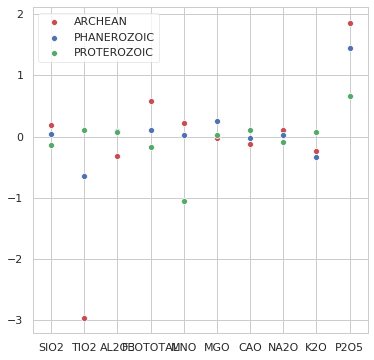

In [55]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("deep")
sns.scatterplot(x=X.columns, y=svc_major.coef_[0], label=svc_major.classes_[0], color="r")
sns.scatterplot(x=X.columns, y=svc_major.coef_[1], label=svc_major.classes_[1], color="b")
sns.scatterplot(x=X.columns, y=svc_major.coef_[2], label=svc_major.classes_[2], color="g")

So let me take notes without reference to the previous and then compare:
* SiO2 - out of order, Prot lowest
* TiO2 - out of order, Prot highest
* Al2O3 - bounces around between regressions
* FeO - out of order, Prot lowest, Arch highest
* MnO - out of order, Prot much lower
* MgO - increases with time
* CaO - out of order, Prot highest
* Na2O - little effect, Prot lowest
* K2O - out of order, Prot highest
* P2O5 - decreasing with time, ish, Arch highest by a lot second time around

From logistic regression:

SiO2: moves toward mafic from PreC to Phan
TiO2: increases markedly over time
Al2O3: increases markedly in Phan
FeO: decreases markedly in Phan
MnO: decreases over time
MgO: out of order, lowest in Proterozoic
CaO: increases over time
Na2O: out of order, highest in Proterozoic
K2O: much lower in Archean
P2O5: out of order, much the lowest in Proterozoic, highest in Archean

What looks most like a match:
* Al2O3
* FeO, ish
* K2O, ish

But that was wrong.

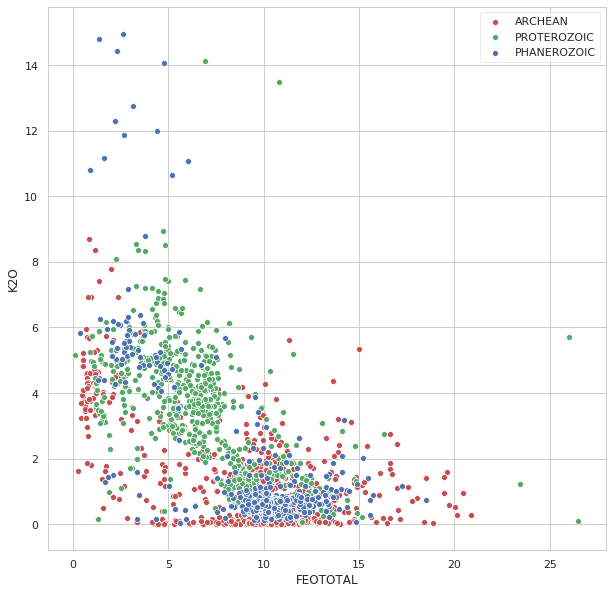

In [56]:
# K2O and FeO actually are important
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("deep")
sns.scatterplot(x='FEOTOTAL', y='K2O', data=major_df[major_df['EON']=='ARCHEAN'],
                label='ARCHEAN', color="r")
sns.scatterplot(x='FEOTOTAL', y='K2O', data=major_df[major_df['EON']=='PROTEROZOIC'],
                label='PROTEROZOIC', color="g")
sns.scatterplot(x='FEOTOTAL', y='K2O', data=major_df[major_df['EON']=='PHANEROZOIC'],
                label='PHANEROZOIC', color="b")

In [57]:
rfc_major.feature_importances_

array([0.14065424, 0.11333456, 0.06145714, 0.11926068, 0.06363015,
       0.09409304, 0.07605689, 0.07279323, 0.15742268, 0.10129741])

In [58]:
rfc_imp = dict(zip(X.columns,rfc_major.feature_importances_))
rfc_imp

{'SIO2': 0.14065423520392084,
 'TIO2': 0.11333456079263368,
 'AL2O3': 0.06145714116599995,
 'FEOTOTAL': 0.11926067783809038,
 'MNO': 0.06363014556945414,
 'MGO': 0.09409303829621811,
 'CAO': 0.07605688758788734,
 'NA2O': 0.07279322513150178,
 'K2O': 0.15742268243821317,
 'P2O5': 0.10129740597608076}

In [59]:
gbf_imp = dict(zip(X.columns,gbf_major.feature_importances_))
gbf_imp

{'SIO2': 0.1911882492162583,
 'TIO2': 0.08200295638126648,
 'AL2O3': 0.03131595624505038,
 'FEOTOTAL': 0.13699778807334062,
 'MNO': 0.056289209077868274,
 'MGO': 0.06005729416212554,
 'CAO': 0.023109785964872426,
 'NA2O': 0.06919012898148791,
 'K2O': 0.2533313704262016,
 'P2O5': 0.09651726147152868}

Oh those are different. Hrm.
* Random Forest top (three): K2O, TiO2, SiO2, FeO was tied last time, lower this time
* Gradient Boost top three: K2O, SiO2/FeO tied last time, still close.

Looks like that calls for more plots:
K2O / FeO / SiO2
K2O / TiO2 / SiO2
K2O / TiO2 / FeO

In [60]:
trace0 = go.Scatter3d(
    x = major_df[major_df['EON']=='ARCHEAN']['SIO2'],
    y = major_df[major_df['EON']=='ARCHEAN']['K2O'],
    z = major_df[major_df['EON']=='ARCHEAN']['FEOTOTAL'],
    name = 'Archean',
    mode = 'markers',
    marker = dict(
        size=3,
        color='red',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace1 = go.Scatter3d(
    x = major_df[major_df['EON']=='PROTEROZOIC']['SIO2'],
    y = major_df[major_df['EON']=='PROTEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PROTEROZOIC']['FEOTOTAL'],
    name = 'Proterozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='green',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace2 = go.Scatter3d(
    x = major_df[major_df['EON']=='PHANEROZOIC']['SIO2'],
    y = major_df[major_df['EON']=='PHANEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PHANEROZOIC']['FEOTOTAL'],
    name = 'Phanerozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='blue',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

data=[trace0, trace1, trace2]

# Modify layout
layout = go.Layout(
    title = 'Major element chemistry by eon, S. Afr. igneous',
    scene =
      dict(
          xaxis = dict(
              title = 'SiO2',
              zeroline = True
          ),
          yaxis = dict(
              title = 'K2O',
              zeroline = True
          ),
          zaxis = dict(
              title = 'FeO (total)',
              zeroline = True
          ),
          hovermode= 'closest'
      )
)

off.iplot(dict(data=data, layout=layout))

In [61]:
trace0 = go.Scatter3d(
    x = major_df[major_df['EON']=='ARCHEAN']['TIO2'],
    y = major_df[major_df['EON']=='ARCHEAN']['K2O'],
    z = major_df[major_df['EON']=='ARCHEAN']['FEOTOTAL'],
    name = 'Archean',
    mode = 'markers',
    marker = dict(
        size=3,
        color='red',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace1 = go.Scatter3d(
    x = major_df[major_df['EON']=='PROTEROZOIC']['TIO2'],
    y = major_df[major_df['EON']=='PROTEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PROTEROZOIC']['FEOTOTAL'],
    name = 'Proterozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='green',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace2 = go.Scatter3d(
    x = major_df[major_df['EON']=='PHANEROZOIC']['TIO2'],
    y = major_df[major_df['EON']=='PHANEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PHANEROZOIC']['FEOTOTAL'],
    name = 'Phanerozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='blue',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

data=[trace0, trace1, trace2]

# Modify layout
layout = go.Layout(
    title = 'Major element chemistry by eon, S. Afr. igneous',
    scene =
      dict(
          xaxis = dict(
              title = 'TiO2',
              zeroline = True
          ),
          yaxis = dict(
              title = 'K2O',
              zeroline = True
          ),
          zaxis = dict(
              title = 'FeO (total)',
              zeroline = True
          ),
          hovermode= 'closest'
      )
)

off.iplot(dict(data=data, layout=layout))

In [62]:
trace0 = go.Scatter3d(
    x = major_df[major_df['EON']=='ARCHEAN']['SIO2'],
    y = major_df[major_df['EON']=='ARCHEAN']['K2O'],
    z = major_df[major_df['EON']=='ARCHEAN']['TIO2'],
    name = 'Archean',
    mode = 'markers',
    marker = dict(
        size=3,
        color='red',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace1 = go.Scatter3d(
    x = major_df[major_df['EON']=='PROTEROZOIC']['SIO2'],
    y = major_df[major_df['EON']=='PROTEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PROTEROZOIC']['TIO2'],
    name = 'Proterozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='green',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

trace2 = go.Scatter3d(
    x = major_df[major_df['EON']=='PHANEROZOIC']['SIO2'],
    y = major_df[major_df['EON']=='PHANEROZOIC']['K2O'],
    z = major_df[major_df['EON']=='PHANEROZOIC']['TIO2'],
    name = 'Phanerozoic',
    mode = 'markers',
    marker = dict(
        size=3,
        color='blue',
        symbol='circle',
        opacity=0.5,
        line=dict(width=1)
     ),
    text=major_df['EON']
)

data=[trace0, trace1, trace2]

# Modify layout
layout = go.Layout(
    title = 'Major element chemistry by eon, S. Afr. igneous',
    scene =
      dict(
          xaxis = dict(
              title = 'SiO2',
              zeroline = True
          ),
          yaxis = dict(
              title = 'K2O',
              zeroline = True
          ),
          zaxis = dict(
              title = 'TiO2',
              zeroline = True
          ),
          hovermode= 'closest'
      )
)

off.iplot(dict(data=data, layout=layout))

All right, I haven't left myself a ton of time to fight through the REE data.

In [63]:
ree_df = df.dropna(subset=['LA'])

In [64]:
ree_only = ree_df[['LA','CE','PR','ND','SM','EU','GD','TB','DY','HO','ER','TM','YB','LU']].astype(float)
ree_eons = ree_df['EON']
ree_data = pd.concat([ree_eons,ree_only],axis=1)

In [65]:
ree_data.fillna(value=0.0,inplace=True)

In [66]:
LU_LA = np.divide(np.array(ree_only['LU']),np.array(ree_only['LA']))

In [67]:
EU_SM = np.divide(np.array(ree_only['EU']),np.array(ree_only['SM']))

/home/paulus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [68]:
ree_data['LU/LA']=LU_LA
ree_data['EU/SM']=EU_SM

In [69]:
ree_data.dtypes

EON       object
LA       float64
CE       float64
PR       float64
ND       float64
SM       float64
EU       float64
GD       float64
TB       float64
DY       float64
HO       float64
ER       float64
TM       float64
YB       float64
LU       float64
LU/LA    float64
EU/SM    float64
dtype: object

In [70]:
ree_data.dropna(inplace=True)
ree_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 49 to 2928
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EON     865 non-null    object 
 1   LA      865 non-null    float64
 2   CE      865 non-null    float64
 3   PR      865 non-null    float64
 4   ND      865 non-null    float64
 5   SM      865 non-null    float64
 6   EU      865 non-null    float64
 7   GD      865 non-null    float64
 8   TB      865 non-null    float64
 9   DY      865 non-null    float64
 10  HO      865 non-null    float64
 11  ER      865 non-null    float64
 12  TM      865 non-null    float64
 13  YB      865 non-null    float64
 14  LU      865 non-null    float64
 15  LU/LA   865 non-null    float64
 16  EU/SM   865 non-null    float64
dtypes: float64(16), object(1)
memory usage: 121.6+ KB


In [71]:
X_train,X_test,y_train,y_test=train_test_split(ree_data.drop(['EON'],axis=1)
                                               ,ree_data['EON'])

In [72]:
X,yo = ree_data.drop(['EON'],axis=1), ree_data['EON']

Mean SVC score:  0.7063583815028902
Individual scores:  [0.54913295 0.67052023 0.87861272 0.84393064 0.58959538]

Train:  0.8287037037037037  Test:  0.8064516129032258


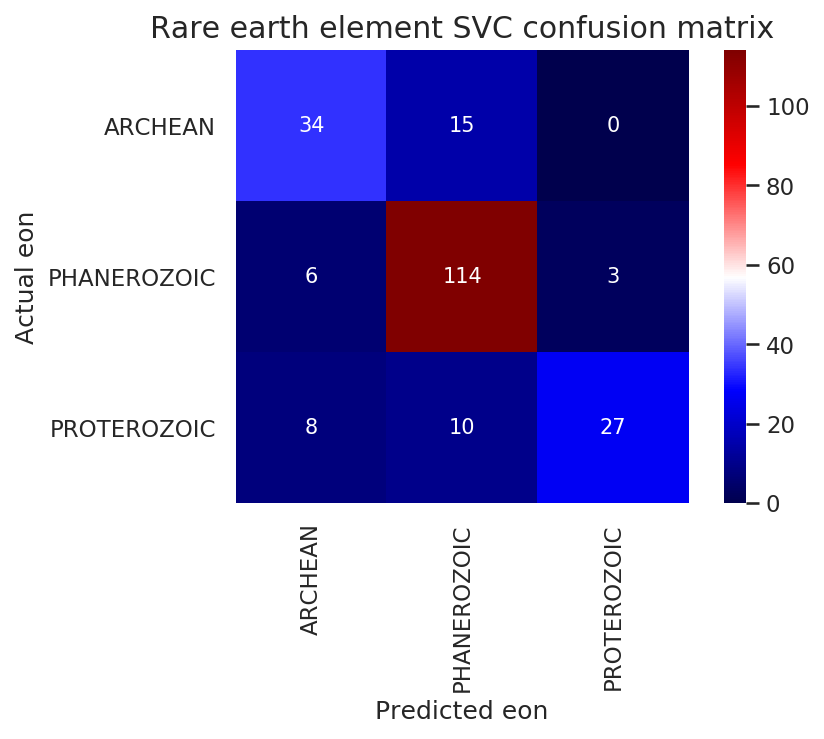

In [73]:
ree_svc = SVC(kernel='linear')
ree_svc_scores = cross_val_score(ree_svc,X,yo)
print("Mean SVC score: ",np.mean(ree_svc_scores))
print("Individual scores: ",ree_svc_scores)
ree_svc.fit(X_train,y_train)
print("\nTrain: ",ree_svc.score(X_train,y_train)," Test: ",ree_svc.score(X_test,y_test))
ree_svc_confusion = confusion_matrix(y_test, ree_svc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ree_svc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ree_svc.classes_,
           yticklabels=ree_svc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Rare earth element SVC confusion matrix');

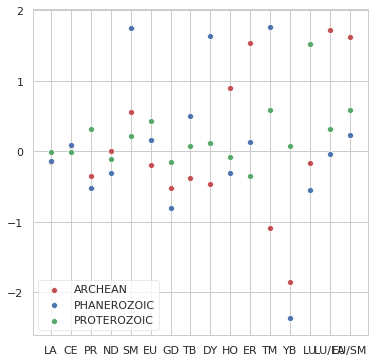

In [74]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("deep")
sns.scatterplot(x=X.columns, y=ree_svc.coef_[0], label=ree_svc.classes_[0], color="r")
sns.scatterplot(x=X.columns, y=ree_svc.coef_[1], label=ree_svc.classes_[1], color="b")
sns.scatterplot(x=X.columns, y=ree_svc.coef_[2], label=ree_svc.classes_[2], color="g")

Mean RFC score:  0.8439306358381502
Individual scores:  [0.76878613 0.89017341 0.93641618 0.92485549 0.69942197]

Train:  1.0  Test:  0.9032258064516129


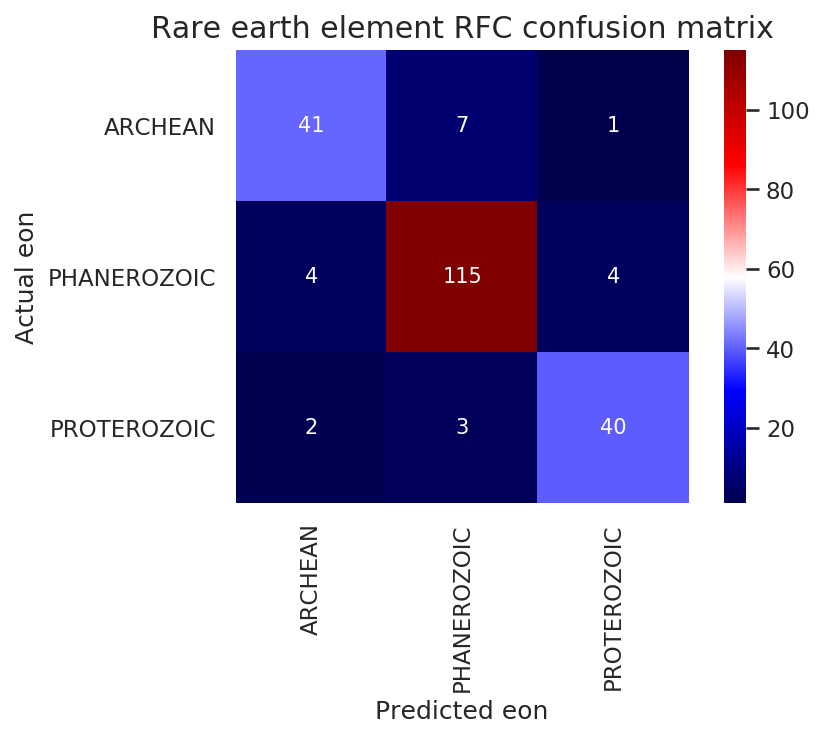

In [75]:
ree_rfc = RandomForestClassifier()
ree_rfc_scores = cross_val_score(ree_rfc,X,yo)
print("Mean RFC score: ",np.mean(ree_rfc_scores))
print("Individual scores: ",ree_rfc_scores)
ree_rfc.fit(X_train,y_train)
print("\nTrain: ",ree_rfc.score(X_train,y_train)," Test: ",ree_rfc.score(X_test,y_test))
ree_rfc_confusion = confusion_matrix(y_test, ree_rfc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ree_rfc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ree_rfc.classes_,
           yticklabels=ree_rfc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Rare earth element RFC confusion matrix');

In [76]:
ree_rfc_imp = dict(zip(X.columns,ree_rfc.feature_importances_))
ree_rfc_imp

{'LA': 0.05485929379128009,
 'CE': 0.06209501514403197,
 'PR': 0.1368611516838476,
 'ND': 0.11706551557379732,
 'SM': 0.03779830629519437,
 'EU': 0.05148792505712132,
 'GD': 0.0657230838849996,
 'TB': 0.042164503330523725,
 'DY': 0.07353396026537115,
 'HO': 0.030013482552142576,
 'ER': 0.0686368187903372,
 'TM': 0.06631102711600516,
 'YB': 0.03978143845906437,
 'LU': 0.042012019826035134,
 'LU/LA': 0.07849859621656805,
 'EU/SM': 0.03315786201368034}

Mean GBF score:  0.8312138728323699
Individual scores:  [0.76300578 0.83815029 0.93063584 0.92485549 0.69942197]

Train:  1.0  Test:  0.880184331797235


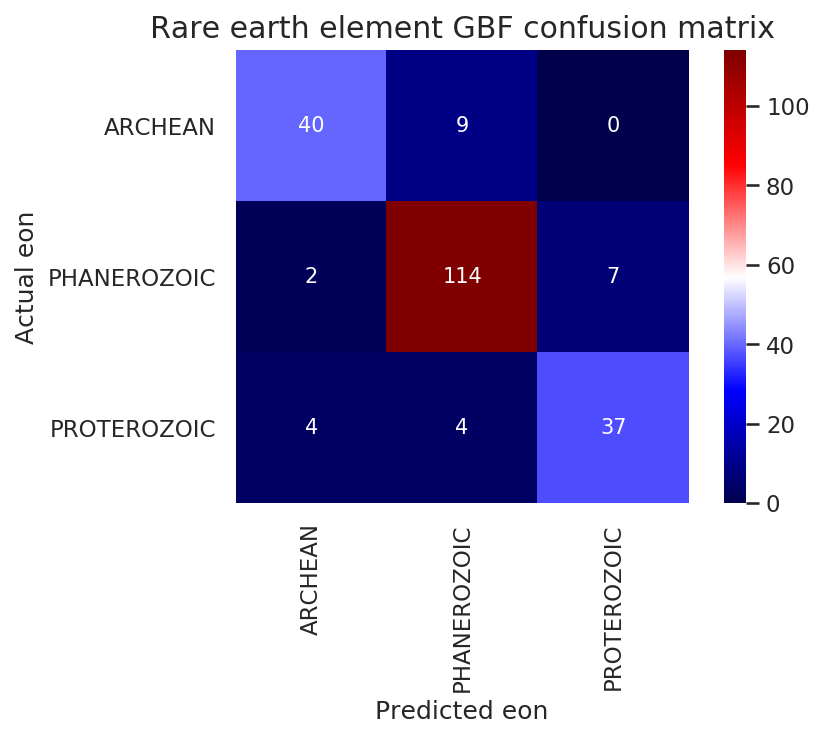

In [77]:
ree_gbf = GradientBoostingClassifier()
ree_gbf_scores = cross_val_score(ree_gbf,X,yo)
print("Mean GBF score: ",np.mean(ree_gbf_scores))
print("Individual scores: ",ree_gbf_scores)
ree_gbf.fit(X_train,y_train)
print("\nTrain: ",ree_gbf.score(X_train,y_train)," Test: ",ree_gbf.score(X_test,y_test))
ree_gbf_confusion = confusion_matrix(y_test, ree_gbf.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ree_gbf_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ree_gbf.classes_,
           yticklabels=ree_gbf.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Rare earth element GBF confusion matrix');

In [78]:
ree_gbf_imp = dict(zip(X.columns,ree_gbf.feature_importances_))
ree_gbf_imp

{'LA': 0.02212740245450637,
 'CE': 0.010990292431860602,
 'PR': 0.20701997857857893,
 'ND': 0.20879136114285046,
 'SM': 0.015203418475341573,
 'EU': 0.038010086282908806,
 'GD': 0.027907271058827364,
 'TB': 0.047018371951219814,
 'DY': 0.018643958184370753,
 'HO': 0.056114310850610936,
 'ER': 0.032038160563096676,
 'TM': 0.07401702097203196,
 'YB': 0.024747397137071667,
 'LU': 0.020857217962706065,
 'LU/LA': 0.16373106617102962,
 'EU/SM': 0.03278268578298852}

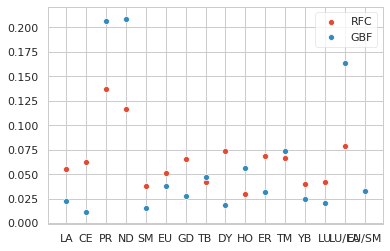

In [79]:
sns.scatterplot(x=X.columns,y=ree_rfc.feature_importances_,label='RFC')
sns.scatterplot(x=X.columns,y=ree_gbf.feature_importances_,label='GBF')

Praseodymium and neodymium being clearly the most important features is in no way anything that I expected.

Once I cleared out the duplicated ratio La/Lu, Lu/La turns out to be an important feature in the forest models. I'm surprised the europium anomaly ratio is not.

Right, then. Major element ratios:
* Mg# = Mg/(Mg+Fe)
* Calc-alkali = Ca/(Na+K)
* Fe/Mn
* Si/Al
* Si/Ti

In [47]:
ratios_df = pd.concat([major_df['EON'],
                      major_df['MGO']/(major_df['MGO']+major_df['FEOTOTAL'])*100,
                      major_df['CAO']/(major_df['NA2O']+major_df['K2O']),
                      major_df['FEOTOTAL']/major_df['MNO'],
                      major_df['SIO2']/major_df['AL2O3'],
                      major_df['SIO2']/major_df['TIO2']],axis=1)
ratios_df.columns = ['Eon','Mg#','Ca/Alk','Fe/Mn','Si/Al','Si/Ti']

In [48]:
ratios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2180 entries, 0 to 2998
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Eon     2180 non-null   object 
 1   Mg#     2063 non-null   float64
 2   Ca/Alk  2168 non-null   float64
 3   Fe/Mn   2017 non-null   float64
 4   Si/Al   2178 non-null   float64
 5   Si/Ti   2176 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.2+ KB


In [49]:
ratios_df.replace(to_replace=np.inf,value=np.nan,inplace=True)
ratios_df.dropna(inplace=True)
ratios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 2998
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Eon     1963 non-null   object 
 1   Mg#     1963 non-null   float64
 2   Ca/Alk  1963 non-null   float64
 3   Fe/Mn   1963 non-null   float64
 4   Si/Al   1963 non-null   float64
 5   Si/Ti   1963 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.4+ KB


In [50]:
X_train,X_test,y_train,y_test = train_test_split(ratios_df.drop(['Eon'],axis=1),
                                                 ratios_df['Eon'])
X,yo = ratios_df.drop(['Eon'],axis=1),ratios_df['Eon']

Mean SVC score:  0.6821480500597186
Individual scores:  [0.5394402  0.6870229  0.76335878 0.74744898 0.67346939]

Train:  0.7228260869565217  Test:  0.670061099796334


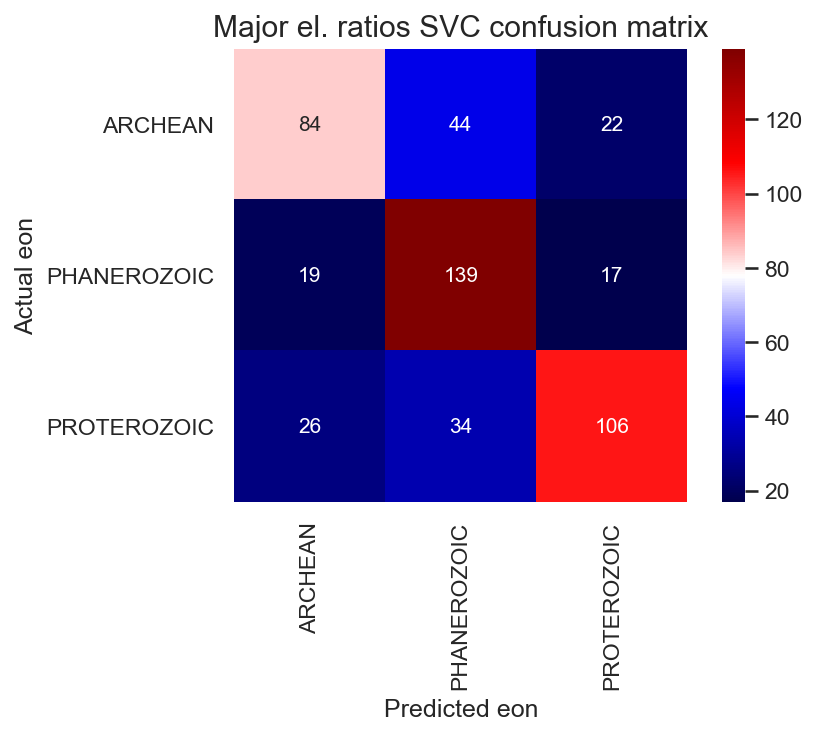

In [51]:
ratio_svc = SVC(kernel='linear')
ratio_svc_scores = cross_val_score(ratio_svc,X,yo)
print("Mean SVC score: ",np.mean(ratio_svc_scores))
print("Individual scores: ",ratio_svc_scores)
ratio_svc.fit(X_train,y_train)
print("\nTrain: ",ratio_svc.score(X_train,y_train)," Test: ",ratio_svc.score(X_test,y_test))
ratio_svc_confusion = confusion_matrix(y_test, ratio_svc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ratio_svc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ratio_svc.classes_,
           yticklabels=ratio_svc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. ratios SVC confusion matrix');

In [52]:
print(len(ratio_svc.support_vectors_),"support vectors: ", ratio_svc.support_vectors_)
print(len(ratio_svc.dual_coef_),"coefficients: ", ratio_svc.dual_coef_)
print("intercept: ", ratio_svc.intercept_)

976 support vectors:  [[ 15.12688624   0.73584906  30.10644099   4.68852459  36.43312102]
 [ 29.97483206   4.46086957  59.76604672   2.79738155  43.5631068 ]
 [ 24.41576557   1.65023474  60.36642871   4.10758621  53.65765766]
 ...
 [ 44.78870975   3.42182891  49.55476235   3.05172414 160.90909091]
 [ 37.56382203   1.99496222  61.14285714   3.82839838  91.75806452]
 [ 34.66761973   2.23076923  53.76470588   3.65584416  97.06896552]]
2 coefficients:  [[ 1.  1.  1. ... -1. -1. -1.]
 [ 1.  0.  1. ... -1. -1. -1.]]
intercept:  [-7.93996155 -1.37373637  1.52565216]


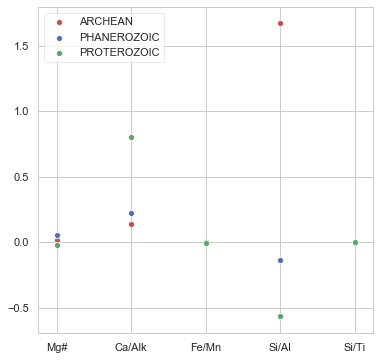

In [53]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("deep")
sns.scatterplot(x=X.columns, y=ratio_svc.coef_[0], label=ratio_svc.classes_[0], color="r")
sns.scatterplot(x=X.columns, y=ratio_svc.coef_[1], label=ratio_svc.classes_[1], color="b")
sns.scatterplot(x=X.columns, y=ratio_svc.coef_[2], label=ratio_svc.classes_[2], color="g")

Mean RFC score:  0.8013332814041647
Individual scores:  [0.66666667 0.81170483 0.90839695 0.87244898 0.74744898]

Train:  1.0  Test:  0.8268839103869654


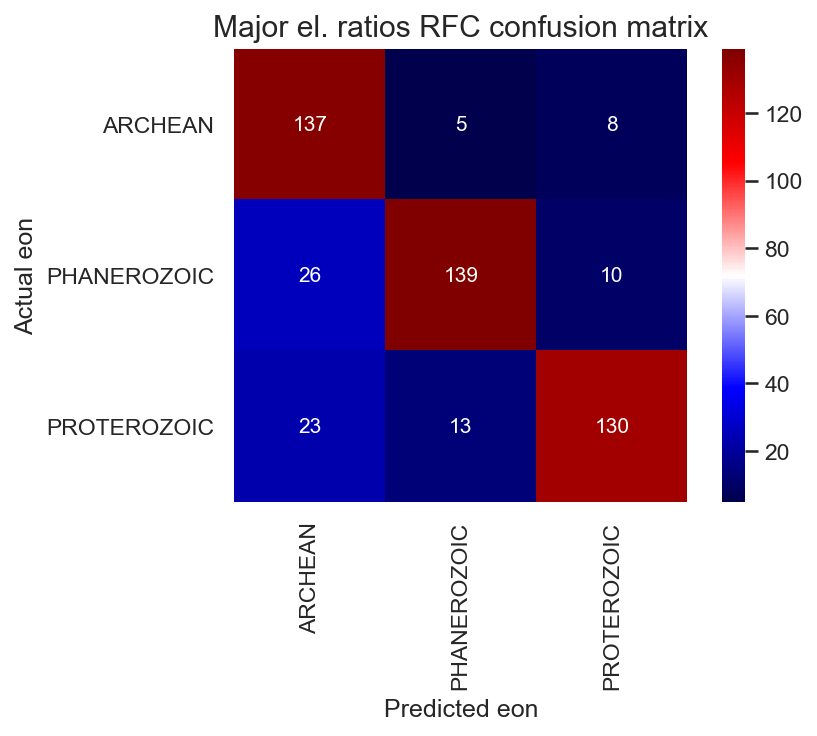

In [55]:
ratio_rfc = RandomForestClassifier()
ratio_rfc_scores = cross_val_score(ratio_rfc,X,yo)
print("Mean RFC score: ",np.mean(ratio_rfc_scores))
print("Individual scores: ",ratio_rfc_scores)
ratio_rfc.fit(X_train,y_train)
print("\nTrain: ",ratio_rfc.score(X_train,y_train)," Test: ",ratio_rfc.score(X_test,y_test))
ratio_rfc_confusion = confusion_matrix(y_test, ratio_rfc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ratio_rfc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ratio_rfc.classes_,
           yticklabels=ratio_rfc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. ratios RFC confusion matrix');

In [56]:
ratio_rfc_imp = dict(zip(X.columns,ratio_rfc.feature_importances_))
ratio_rfc_imp

{'Mg#': 0.20527832624111375,
 'Ca/Alk': 0.23143087029546083,
 'Fe/Mn': 0.09316345940680183,
 'Si/Al': 0.22860369127708646,
 'Si/Ti': 0.2415236527795372}

In [57]:
ratio_gbf = GradientBoostingClassifier()
ratio_gbf_scores = cross_val_score(ratio_gbf,X,yo)
print("Mean GBF score: ",np.mean(ratio_gbf_scores))
print("Individual scores: ",ratio_gbf_scores)
ratio_gbf.fit(X_train,y_train)
print("\nTrain: ",ratio_gbf.score(X_train,y_train)," Test: ",ratio_gbf.score(X_test,y_test))

Mean GBF score:  0.8018305031936439
Individual scores:  [0.67175573 0.82188295 0.91857506 0.85969388 0.7372449 ]

Train:  0.9476902173913043  Test:  0.824847250509165


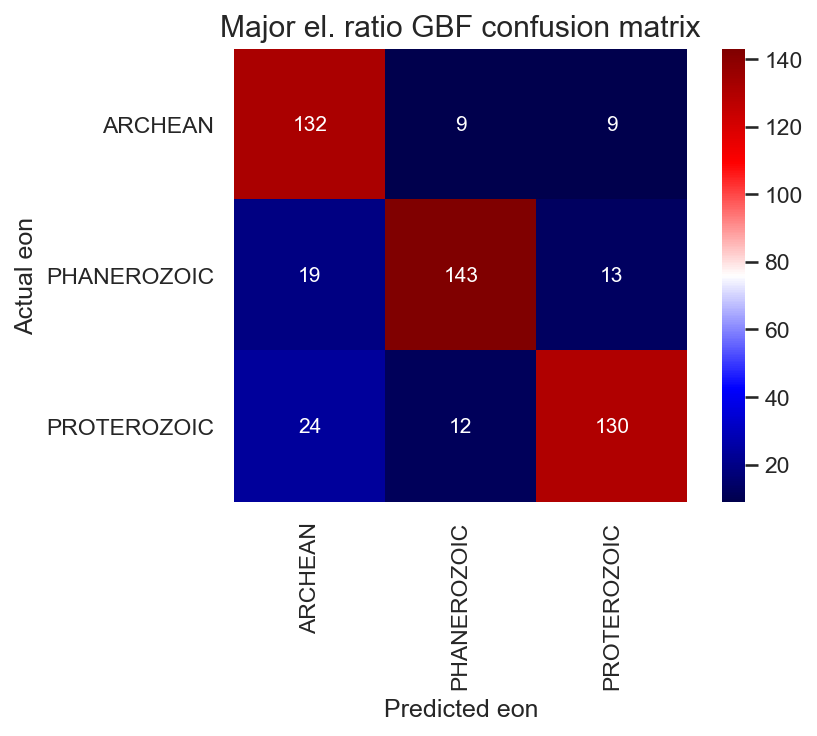

In [58]:
ratio_gbf_confusion = confusion_matrix(y_test, ratio_gbf.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(ratio_gbf_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=ratio_gbf.classes_,
           yticklabels=ratio_gbf.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. ratio GBF confusion matrix');

In [59]:
prfs(y_test, ratio_gbf.predict(X_test))

(array([0.75428571, 0.87195122, 0.85526316]),
 array([0.88      , 0.81714286, 0.78313253]),
 array([0.81230769, 0.84365782, 0.81761006]),
 array([150, 175, 166]))

In [60]:
ratio_gbf_imp = dict(zip(X.columns,ratio_gbf.feature_importances_))
ratio_gbf_imp

{'Mg#': 0.18746135838586633,
 'Ca/Alk': 0.26480504203426625,
 'Fe/Mn': 0.06211686248051057,
 'Si/Al': 0.25451016009862165,
 'Si/Ti': 0.23110657700073517}

Might continue feature engineering by dropping Fe/Mn and replacing it with something that focuses more on K, or P, or do some more thinking. Would be important to see if nearly all the accuracy in the all-major-element classifiers can be recovered by a suite of only 5 to 7 ratios.

Then, if one wanted to get really fancy-dancy, one could throw in Pr, Nd, Lu/La.

Also, worth going back and
* standardizing the variables
* using a logistic regression with lasso / elastic net to eliminate features.

F it. Let's do that first. Here we go. Hang on tight.

In [62]:
grand_df = major_df[['EON','SIO2','TIO2','AL2O3','FEOTOTAL','MNO','MGO','CAO',
          'NA2O','K2O','P2O5',
          'LA','CE','PR','ND','SM','EU','GD','TB','DY','HO','ER','TM','YB','LU']].copy()

In [63]:
rat_df = pd.concat([major_df['MGO']/(major_df['MGO']+major_df['FEOTOTAL'])*100,
                      major_df['CAO']/(major_df['NA2O']+major_df['K2O']),
                      major_df['FEOTOTAL']/major_df['MNO'],
                      major_df['SIO2']/major_df['AL2O3'],
                      major_df['SIO2']/major_df['TIO2']],axis=1)
rat_df.columns = ['Mg#','Ca/Alk','Fe/Mn','Si/Al','Si/Ti']
grand_df = pd.concat([grand_df,rat_df],axis=1)
grand_df.columns

Index(['EON', 'SIO2', 'TIO2', 'AL2O3', 'FEOTOTAL', 'MNO', 'MGO', 'CAO', 'NA2O',
       'K2O', 'P2O5', 'LA', 'CE', 'PR', 'ND', 'SM', 'EU', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'Mg#', 'Ca/Alk', 'Fe/Mn', 'Si/Al',
       'Si/Ti'],
      dtype='object')

In [64]:
rrat_df = pd.concat([major_df['LU']/major_df['LA'],major_df['EU']/major_df['SM']],axis=1)
rrat_df.columns = ['LU/LA','EU/SM']

In [65]:
grand_df = pd.concat([grand_df,rrat_df],axis=1)
grand_df.columns

Index(['EON', 'SIO2', 'TIO2', 'AL2O3', 'FEOTOTAL', 'MNO', 'MGO', 'CAO', 'NA2O',
       'K2O', 'P2O5', 'LA', 'CE', 'PR', 'ND', 'SM', 'EU', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'Mg#', 'Ca/Alk', 'Fe/Mn', 'Si/Al',
       'Si/Ti', 'LU/LA', 'EU/SM'],
      dtype='object')

In [66]:
grand_df.replace(to_replace=np.inf,value=np.nan,inplace=True)
grand_df.dropna(inplace=True)
grand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 127 to 2928
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EON       417 non-null    object 
 1   SIO2      417 non-null    float64
 2   TIO2      417 non-null    float64
 3   AL2O3     417 non-null    float64
 4   FEOTOTAL  417 non-null    float64
 5   MNO       417 non-null    float64
 6   MGO       417 non-null    float64
 7   CAO       417 non-null    float64
 8   NA2O      417 non-null    float64
 9   K2O       417 non-null    float64
 10  P2O5      417 non-null    float64
 11  LA        417 non-null    float64
 12  CE        417 non-null    float64
 13  PR        417 non-null    float64
 14  ND        417 non-null    float64
 15  SM        417 non-null    float64
 16  EU        417 non-null    float64
 17  GD        417 non-null    float64
 18  TB        417 non-null    float64
 19  DY        417 non-null    float64
 20  HO        417 non-null    flo

In [67]:
X=np.array(grand_df.drop(['EON'],axis=1))
y=grand_df['EON']

Hooo, not many data points left.
Let's do a straight lasso and try to knock out everything we can.

"The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver."

    solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

Algorithm to use in the optimization problem.

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

‘liblinear’ and ‘saga’ also handle L1 penalty

‘saga’ also supports ‘elasticnet’ penalty

‘liblinear’ does not support setting penalty='none'

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [68]:
scaler = MinMaxScaler()
X_tr,X_tst,y_tr,y_tst = train_test_split(X,y)
X_scale = scaler.fit_transform(X_tr)
X_tstsc = scaler.transform(X_tst)

In [98]:
grand_loge = LogisticRegression(penalty='l1',C=0.5,solver='liblinear')

Mean cross-validation score:  0.8827022375215148
Individual scores:  [0.77380952 0.9047619  0.92771084 0.92771084 0.87951807]

Train:  0.8397435897435898  Test:  0.7904761904761904


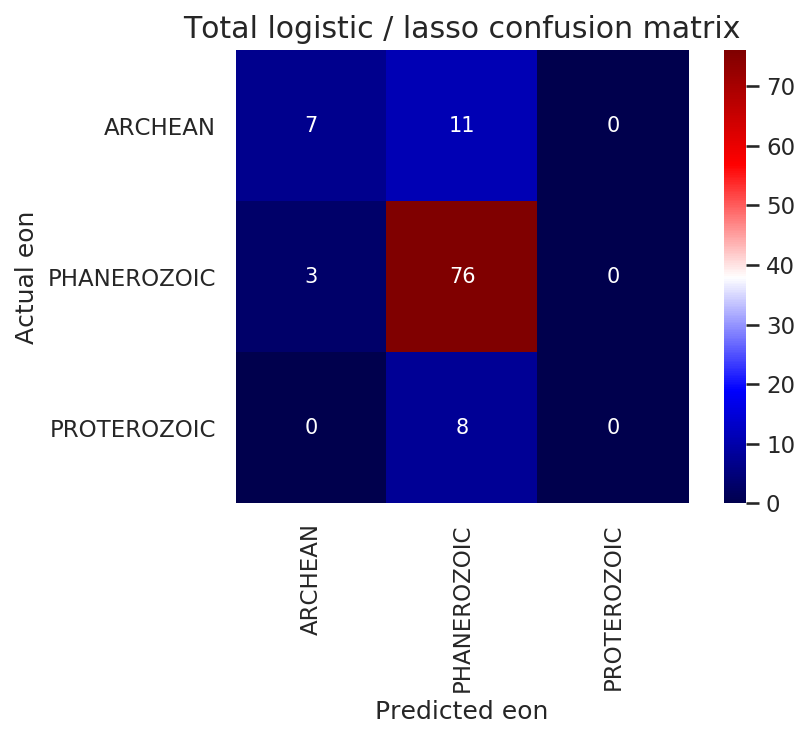

In [99]:
grand_loge_scores = cross_val_score(grand_loge,X,y)
print("Mean cross-validation score: ",np.mean(grand_loge_scores))
print("Individual scores: ",grand_loge_scores)
grand_loge.fit(X_scale,y_tr)
print("\nTrain: ",grand_loge.score(X_scale,y_tr)," Test: ",
      grand_loge.score(X_tstsc,y_tst))
grand_loge_confusion = confusion_matrix(y_tst, grand_loge.predict(X_tstsc))
plt.figure(dpi=150)
sns.heatmap(grand_loge_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=grand_loge.classes_,
           yticklabels=grand_loge.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Total logistic / lasso confusion matrix');

Ok, so that can't be done... not enough coverage.

The only "major" element not in the ratios already is P2O5. Let's dump FeO/MnO and either use raw P2O5 or SiO2/P2O5. We'll stick with a ratio.

In [69]:
Si_P = major_df['SIO2']/major_df['P2O5']
rat_df = pd.concat([major_df['EON'],rat_df,Si_P],axis=1)
rat_df.columns = ['EON','Mg#','Ca/Alk','Fe/Mn','Si/Al','Si/Ti','Si/P']

In [70]:
del rat_df['Fe/Mn']

In [71]:
rat_df.replace(to_replace=np.inf,value=np.nan,inplace=True)
rat_df.dropna(inplace=True)
rat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 2998
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EON     2004 non-null   object 
 1   Mg#     2004 non-null   float64
 2   Ca/Alk  2004 non-null   float64
 3   Si/Al   2004 non-null   float64
 4   Si/Ti   2004 non-null   float64
 5   Si/P    2004 non-null   float64
dtypes: float64(5), object(1)
memory usage: 109.6+ KB


In [72]:
X,yo = rat_df.drop(['EON'],axis=1),rat_df['EON']
scaler = MinMaxScaler()
X_tr,X_tst,y_train,y_test = train_test_split(X,yo)
X_train = scaler.fit_transform(X_tr)
X_test = scaler.transform(X_tst)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScale

Mean SVC score:  0.36530548628428927
Individual scores:  [0.3117207  0.30174564 0.41645885 0.35910224 0.4375    ]

Train:  0.5608782435129741  Test:  0.564870259481038


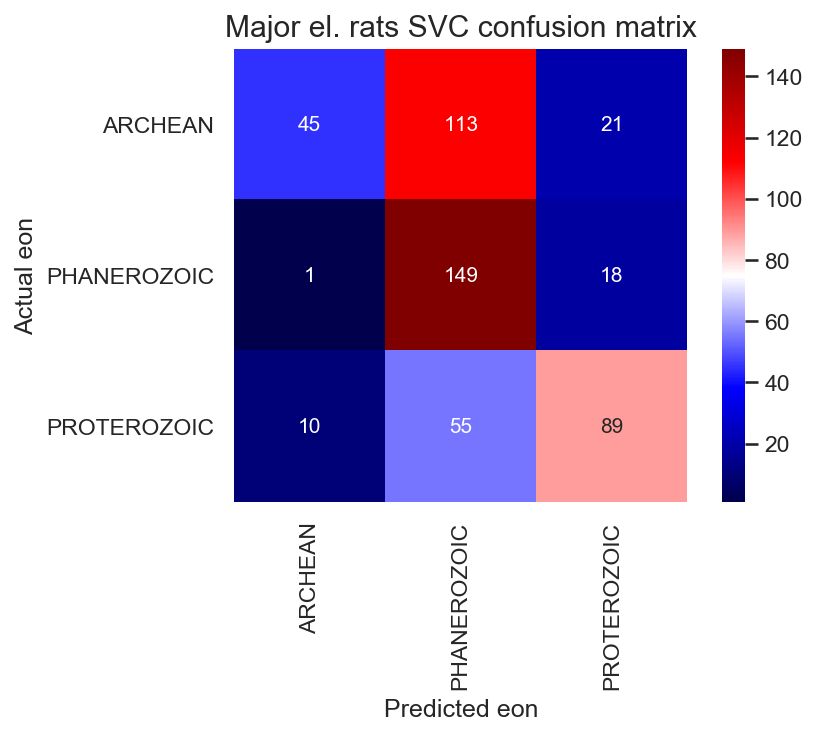

In [73]:
rat_svc = SVC(kernel='linear',C=0.5,max_iter=5000,tol=0.01)
rat_svc_scores = cross_val_score(rat_svc,X,yo)
print("Mean SVC score: ",np.mean(rat_svc_scores))
print("Individual scores: ",rat_svc_scores)
rat_svc.fit(X_train,y_train)
print("\nTrain: ",rat_svc.score(X_train,y_train)," Test: ",rat_svc.score(X_test,y_test))
rat_svc_confusion = confusion_matrix(y_test, rat_svc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rat_svc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=rat_svc.classes_,
           yticklabels=rat_svc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. rats SVC confusion matrix');

Si/P seems to be breaking the SVC algorithm hard.

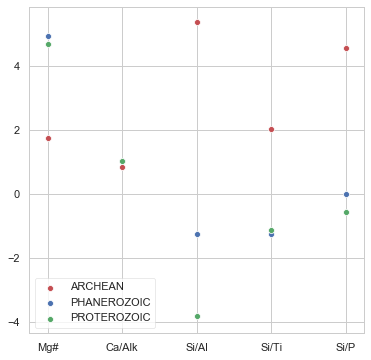

In [74]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("deep")
sns.scatterplot(x=X.columns, y=rat_svc.coef_[0], label=rat_svc.classes_[0], color="r")
sns.scatterplot(x=X.columns, y=rat_svc.coef_[1], label=rat_svc.classes_[1], color="b")
sns.scatterplot(x=X.columns, y=rat_svc.coef_[2], label=rat_svc.classes_[2], color="g")

Mean RFC score:  0.8138491271820449
Individual scores:  [0.680798   0.83541147 0.93516209 0.85037406 0.7675    ]

Train:  1.0  Test:  0.8662674650698603


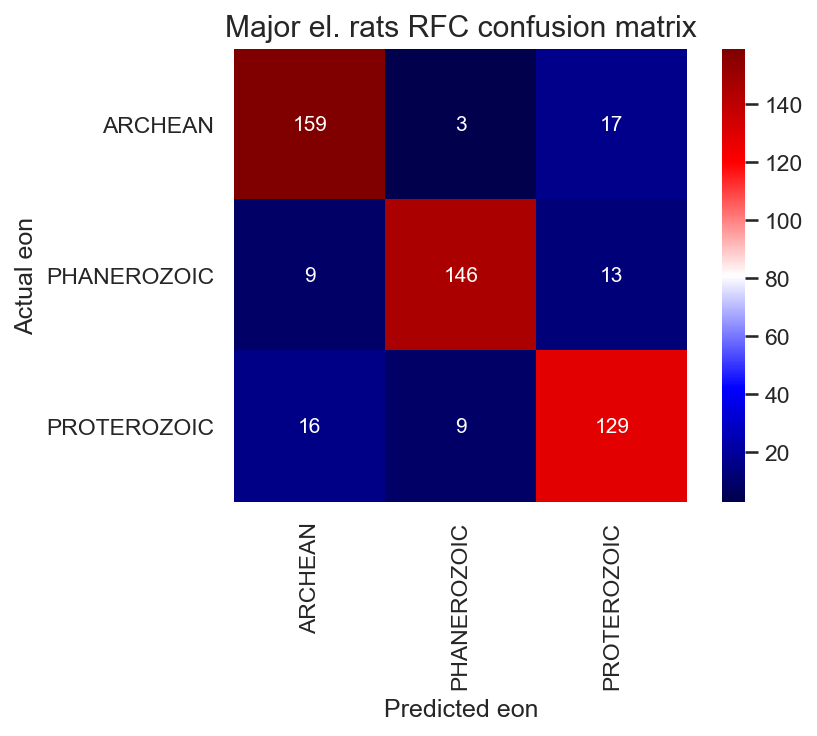

In [75]:
rat_rfc = RandomForestClassifier()
rat_rfc_scores = cross_val_score(rat_rfc,X,yo)
print("Mean RFC score: ",np.mean(rat_rfc_scores))
print("Individual scores: ",rat_rfc_scores)
rat_rfc.fit(X_train,y_train)
print("\nTrain: ",rat_rfc.score(X_train,y_train)," Test: ",rat_rfc.score(X_test,y_test))
rat_rfc_confusion = confusion_matrix(y_test, rat_rfc.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rat_rfc_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=rat_rfc.classes_,
           yticklabels=rat_rfc.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. rats RFC confusion matrix');

In [76]:
rat_rfc_imp = dict(zip(X.columns,rat_rfc.feature_importances_))
rat_rfc_imp

{'Mg#': 0.1982076732788195,
 'Ca/Alk': 0.19744847465025891,
 'Si/Al': 0.20933211597773632,
 'Si/Ti': 0.22258099728661943,
 'Si/P': 0.17243073880656595}

Mean GBF score:  0.809356608478803
Individual scores:  [0.6957606  0.83042394 0.9127182  0.8478803  0.76      ]

Train:  0.9441117764471058  Test:  0.8502994011976048


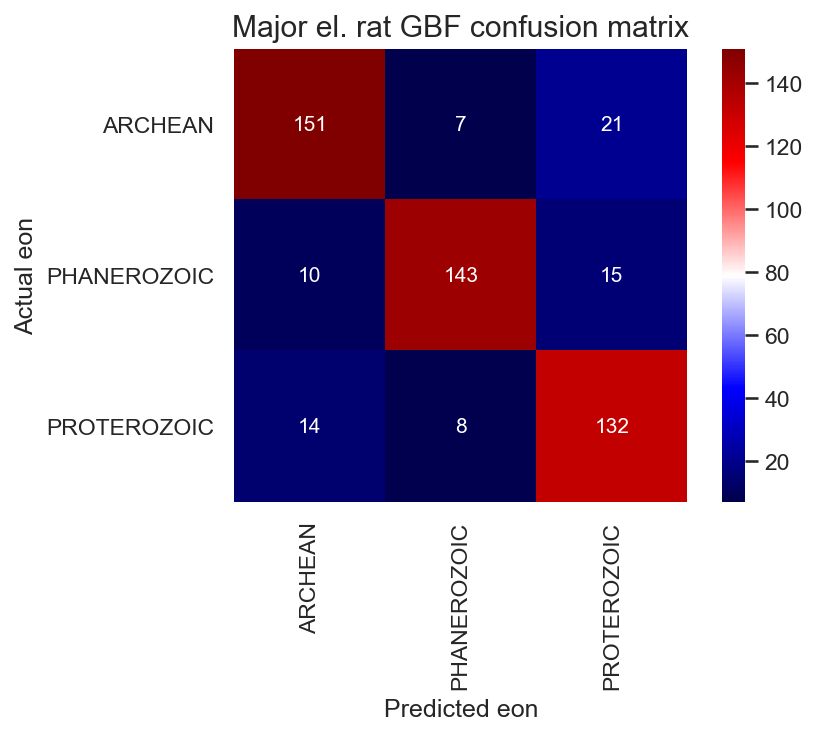

In [77]:
rat_gbf = GradientBoostingClassifier()
rat_gbf_scores = cross_val_score(rat_gbf,X,yo)
print("Mean GBF score: ",np.mean(rat_gbf_scores))
print("Individual scores: ",rat_gbf_scores)
rat_gbf.fit(X_train,y_train)
print("\nTrain: ",rat_gbf.score(X_train,y_train)," Test: ",rat_gbf.score(X_test,y_test))
rat_gbf_confusion = confusion_matrix(y_test, rat_gbf.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rat_gbf_confusion, cmap=plt.cm.seismic, annot=True, square=True,
           xticklabels=rat_gbf.classes_,
           yticklabels=rat_gbf.classes_,
           fmt=".0f")
plt.xlabel('Predicted eon')
plt.ylabel('Actual eon')
plt.title('Major el. rat GBF confusion matrix');

In [78]:
rat_gbf_imp = dict(zip(X.columns,rat_gbf.feature_importances_))
rat_gbf_imp

{'Mg#': 0.16113832443980755,
 'Ca/Alk': 0.20358671290050814,
 'Si/Al': 0.25718811050574836,
 'Si/Ti': 0.22441777533106777,
 'Si/P': 0.15366907682286812}

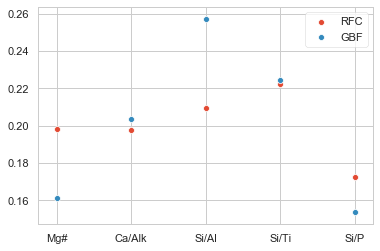

In [79]:
sns.scatterplot(x=X.columns,y=rat_rfc.feature_importances_,label='RFC')
sns.scatterplot(x=X.columns,y=rat_gbf.feature_importances_,label='GBF')

In [116]:
ratio_tree = DecisionTreeClassifier(max_depth=5)
ratio_tree.fit(X_train,y_train)
print("Train: ",ratio_tree.score(X_train,y_train)," Test: ",
      ratio_tree.score(X_test,y_test))

Train:  0.8396540252827678  Test:  0.7944111776447106


In [123]:
ratio_list = X.columns

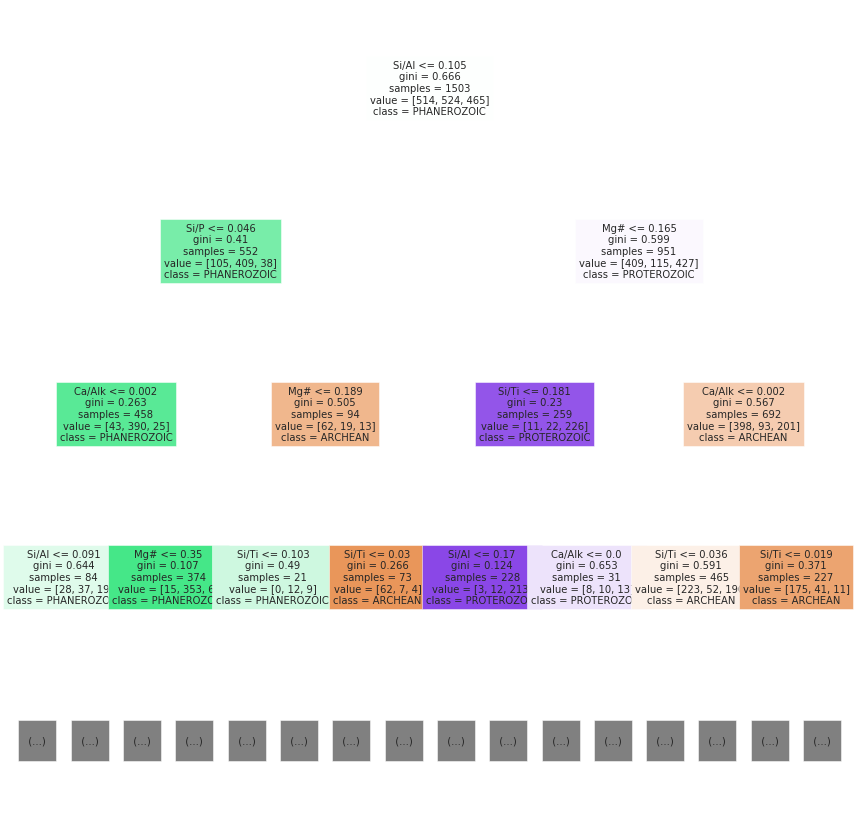

In [124]:
plt.subplots(figsize=(15, 15))
plot_tree(ratio_tree,feature_names=ratio_list,class_names=list(ratio_tree.classes_),
         filled=True,rotate=True,max_depth=3,fontsize=10)
plt.show();

In [ ]:
ration_df = pd.concat([major_df['MGO']/(major_df['MGO']+major_df['FEOTOTAL'])*100,
                      major_df['CAO']/(major_df['NA2O']+major_df['K2O']),
                      major_df['SIO2']/major_df['AL2O3'],
                      major_df['SIO2']/major_df['TIO2'],
                      major_df['SIO2']/major_df['P2O5']],axis=1)
ration_df.columns = ['Mg#','Ca/Alk','Fe/Mn','Si/Al','Si/Ti']
huge_df = pd.concat[[major_df,ration_df],axis=1]
